In [1]:
import random 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 



from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler


from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils.class_weight import compute_class_weight


In [4]:

random.seed(42)

In [5]:


df = pd.read_csv("data.csv")
df.head(2)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0



<br>

**Vehicle insurance:** is a contract where you pay premiums to an insurer for financial protection against losses from accidents, theft, or damage to your car, covering your own repair costs, injuries, and legal liability for damage or harm you cause to others.

<br>


* **Gender**: Customer gender (Male / Female)
* **Age**: Customer’s age
* **Driving_License**:

  * `1` → Has driving license
  * `0` → Does not have driving license
* **Region_Code**: Encoded region information
* **Previously_Insured**:

  * `1` → Customer already has vehicle insurance
  * `0` → Not previously insured
* **Vehicle_Age**: Age category of the vehicle (`< 1 Year`, `1–2 Years`, `> 2 Years`)
* **Vehicle_Damage**:

  * `Yes` → Vehicle was damaged in the past
  * `No` → No past damage
* **Annual_Premium**: Yearly insurance premium amount
* **Policy_Sales_Channel**: Encoded channel used for selling the policy
* **Vintage**: Number of days the customer has been associated with the company
* **Response (Target Variable)**:

  * `1` → Customer is interested in the insurance
  * `0` → Customer is not interested

<br>
<br>

**Annual_Premium:** <br>
✔ Yes, 40454 is money you pay and usually don’t get back. <br>
✔ It is the cost of risk protection, not savings. <br>

<br>


In [6]:


df.isnull().sum().sum().item()


0

In [7]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [8]:

print(df["Gender"].unique())
print(df["Driving_License"].unique())
print(df["Previously_Insured"].unique())
print(df["Vehicle_Age"].unique())
print(df["Vehicle_Damage"].unique())


['Male' 'Female']
[1 0]
[0 1]
['> 2 Years' '1-2 Year' '< 1 Year']
['Yes' 'No']


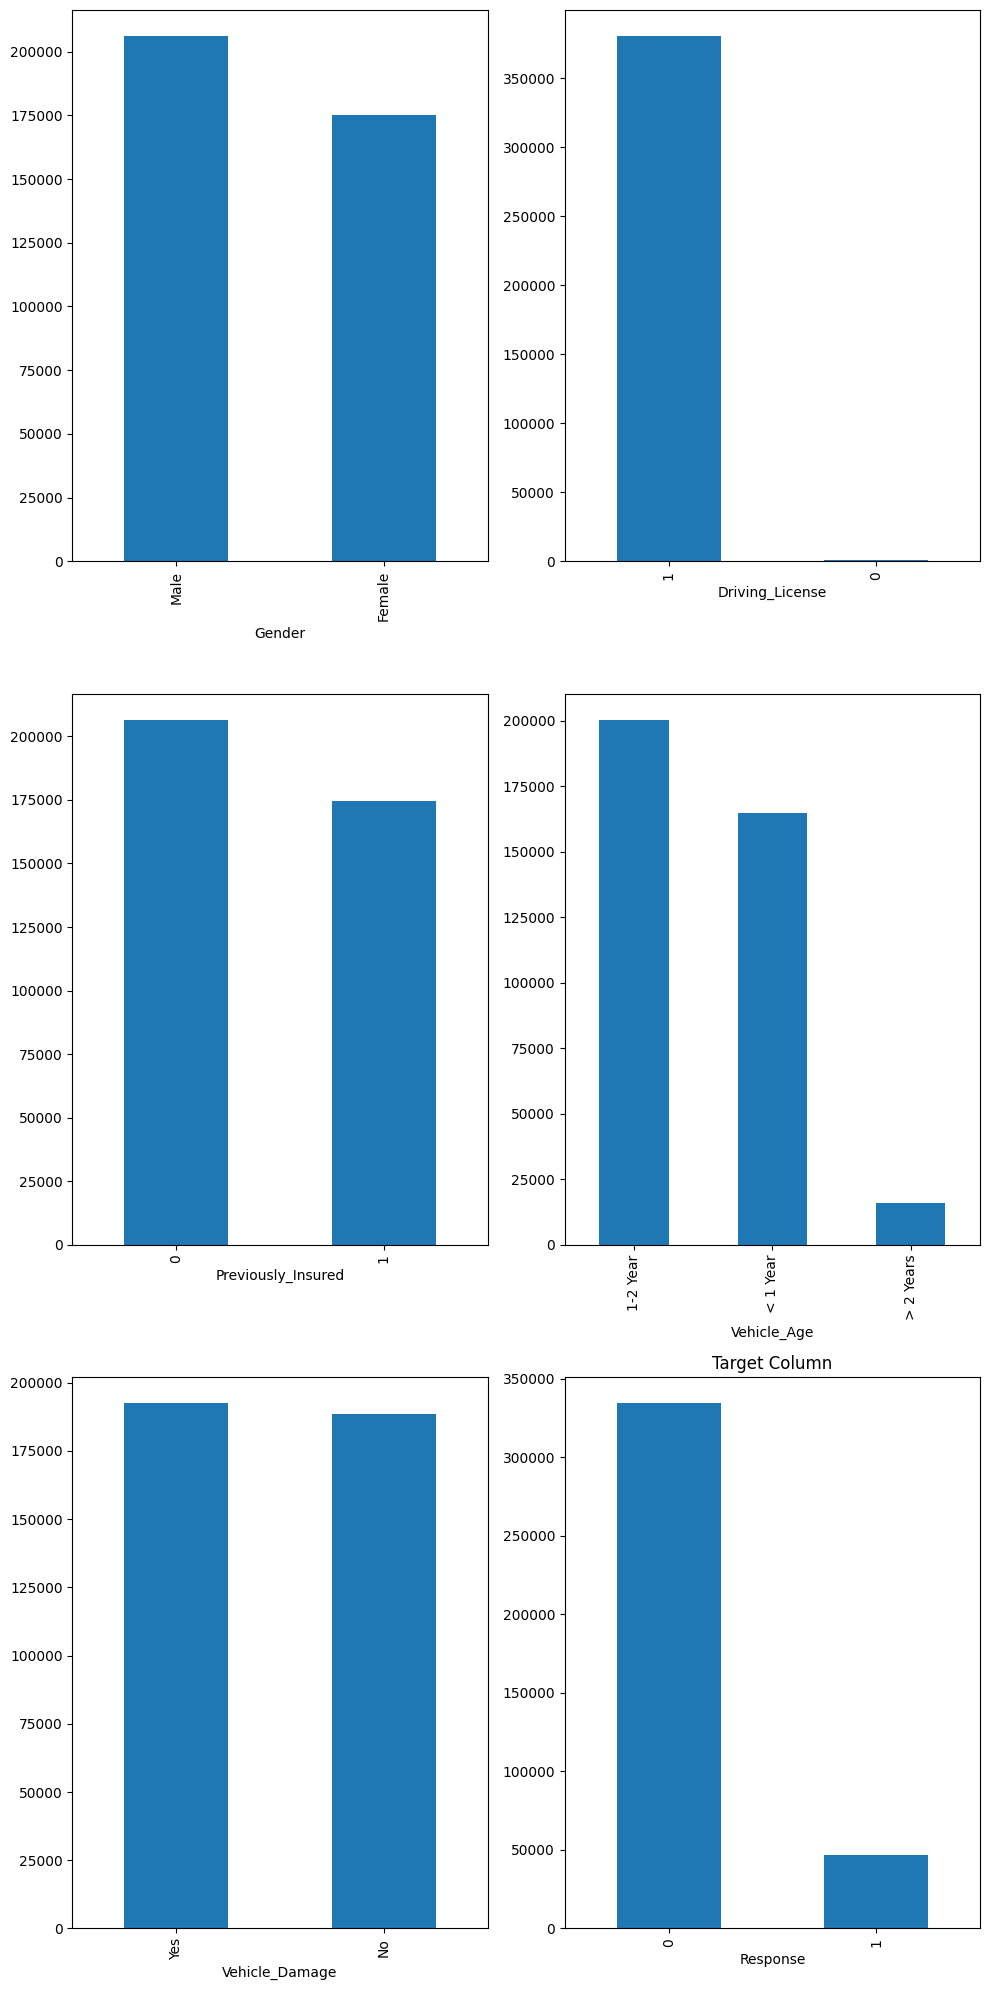

In [9]:

fig,ax = plt.subplots(3,2,figsize=(10,20))

df["Gender"].value_counts().plot(kind="bar",ax=ax[0][0])
df["Driving_License"].value_counts().plot(kind="bar",ax=ax[0][1])
df["Previously_Insured"].value_counts().plot(kind="bar",ax=ax[1][0])
df["Vehicle_Age"].value_counts().plot(kind="bar",ax=ax[1][1])
df["Vehicle_Damage"].value_counts().plot(kind="bar",ax=ax[2][0])

df["Response"].value_counts().plot(kind="bar",ax=ax[2][1])
ax[2][1].set_title("Target Column")
plt.tight_layout()
plt.show()


In [10]:

df = pd.concat([df,pd.get_dummies(df["Gender"],dtype=int)],axis=1)
df = pd.concat([df,pd.get_dummies(df["Vehicle_Age"],dtype=int)],axis=1)
df = pd.concat([df,pd.get_dummies(df["Vehicle_Damage"],dtype=int,prefix="Damage")],axis=1)


In [11]:

object = df.select_dtypes(include=["object"]).columns
object

Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')

In [12]:

df_final = df.drop(columns=object)
df_final.columns

Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response',
       'Female', 'Male', '1-2 Year', '< 1 Year', '> 2 Years', 'Damage_No',
       'Damage_Yes'],
      dtype='object')

In [13]:


df_final.drop(columns=["id"],inplace=True)


In [14]:

df_final.sample(5)

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Female,Male,1-2 Year,< 1 Year,> 2 Years,Damage_No,Damage_Yes
47296,39,1,11.0,0,28119.0,154.0,200,0,0,1,1,0,0,0,1
325763,27,1,30.0,1,2630.0,152.0,88,0,0,1,0,1,0,1,0
22498,37,1,46.0,0,30479.0,124.0,32,0,0,1,1,0,0,0,1
198877,61,1,46.0,0,2630.0,1.0,65,0,1,0,0,1,0,1,0
74125,27,1,28.0,1,2630.0,152.0,205,0,1,0,0,1,0,1,0


In [15]:

df["Age"].skew()


np.float64(0.6725389977260837)

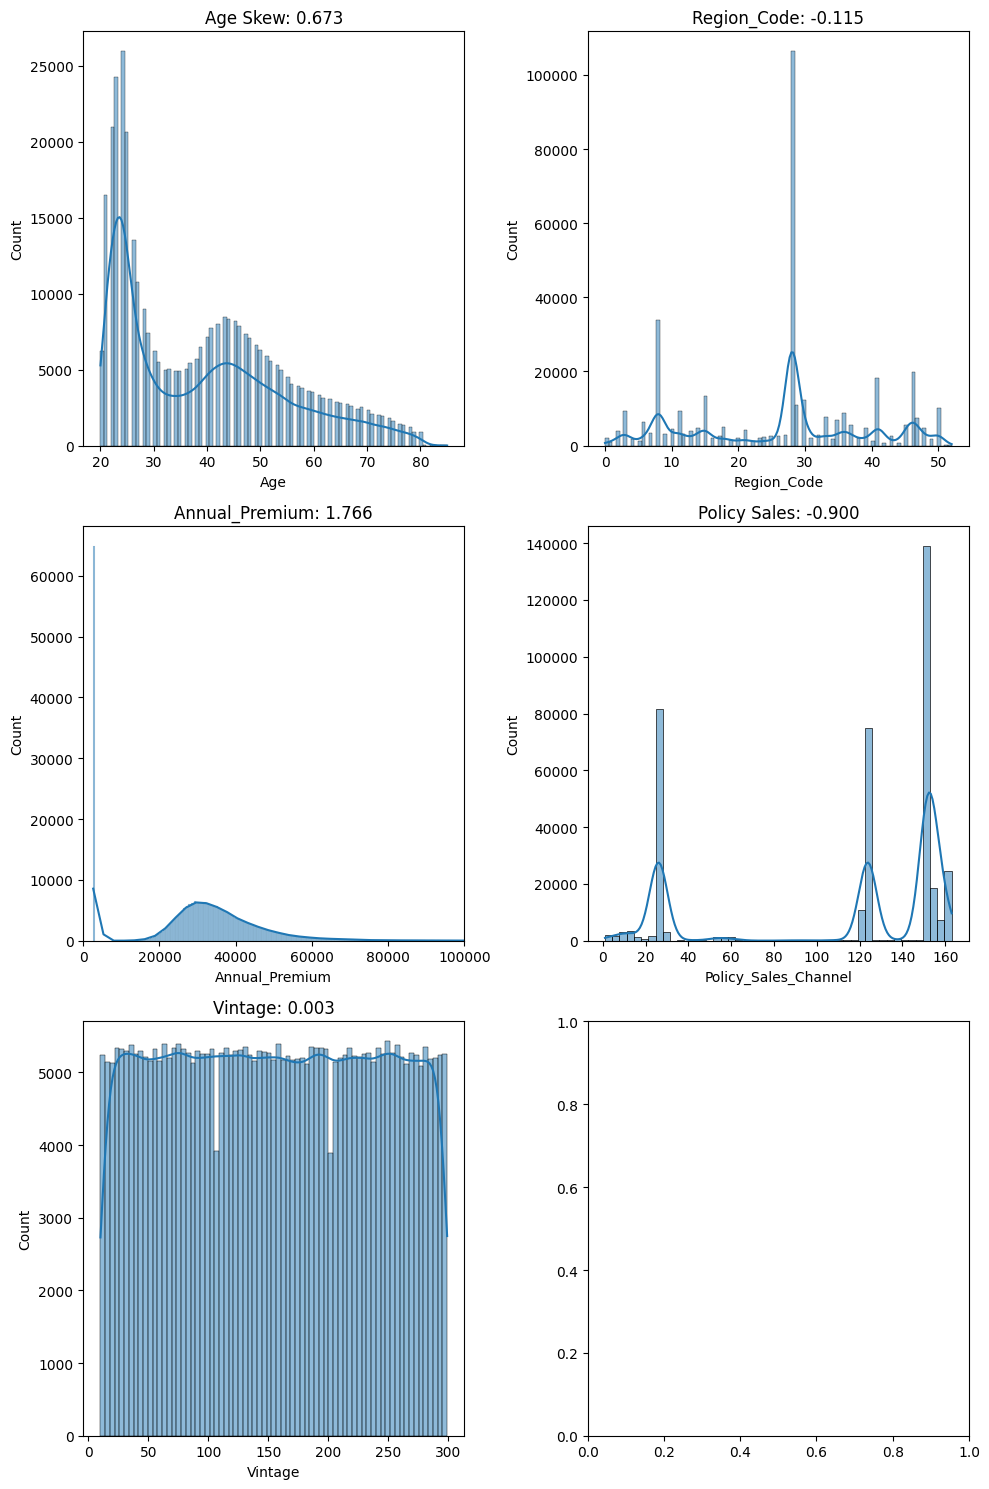

In [16]:
"""
| Skew Value   | Meaning              | Action        |
| ------------ | -------------------- | ------------- |
| −0.5 to +0.5 | Approximately normal | No transform  |
| 0.5 to 1     | Moderate skew        | Optional      |
| **> 1**      | **Strong skew**      | **Transform** |
| > 2          | Extreme              | Mandatory     |
"""

# ====== see the distribution of numerical features: ======
fig, ax = plt.subplots(3,2,figsize=(10,15))


# ============= Age =============
# Age Skew: 0.672 Slight Right-Skewed
    # Most Customers young
sns.histplot(data=df_final,x="Age",kde=True,ax=ax[0][0])
ax[0][0].set_title(f"""Age Skew: {df_final['Age'].skew():.3f}""")



# ============= Region Code =============
# Region_code: -0.115 Slightly Left-Skewed
    # Discrete spikes (Weired for numerical data)
    # Need to treat as categorical data 
sns.histplot(data=df_final,x="Region_Code",kde=True,ax=ax[0][1])
ax[0][1].set_title(f"""Region_Code: {df_final["Region_Code"].skew():.3f}""")



# ============= Annual Premium =============
# Annual Premium: 1.766 Heavy Right-Skewed
    # Huge Spike at small value
    # Need transormation 
sns.histplot(data=df_final,x="Annual_Premium",kde=True,ax=ax[1][0])
ax[1][0].set_xlim(0,100000)
ax[1][0].set_title(f"""Annual_Premium: {df_final["Annual_Premium"].skew():.3f}""")


# ============= Policy Sales Channel =============
# Policy Sales Channel: -0.9  
    # Maybe treat will be good treat as a categorical column
sns.histplot(data=df_final,x="Policy_Sales_Channel",kde=True,ax=ax[1][1])
ax[1][1].set_title(f"""Policy Sales: {df_final["Policy_Sales_Channel"].skew():.3f}""")


# ============= Vintage =============
# Vintage: 0.003 
    # almost uniform 
    # Just need scaling:
sns.histplot(data=df_final,x="Vintage",kde=True,ax=ax[2][0])
ax[2][0].set_title(f"""Vintage: {df_final["Vintage"].skew():.3f}""")


plt.tight_layout()
plt.show()




In [17]:

# apply log transormation:
# log(0) = -INF use log1p or log(1+x)
df_final["Annual_Premium"] = np.log1p(df_final["Annual_Premium"])


In [18]:

# age handle: (Best For Normalization)
age_scaler = MinMaxScaler()
age_scaler.fit(df_final[["Age"]])
df_final["Age"] = age_scaler.fit_transform(df_final[["Age"]])


In [19]:

# vintage: 
vintage_scaler = StandardScaler()
vintage_scaler.fit(df_final[["Vintage"]])
df_final["Vintage"] = vintage_scaler.fit_transform(df_final[["Vintage"]])


In [20]:

df_final.sample(5)


,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Female,Male,1-2 Year,< 1 Year,> 2 Years,Damage_No,Damage_Yes
259722,0.815385,1,48.0,0,7.875119,26.0,1.430033,0,0,1,1,0,0,0,1
139997,0.015385,1,41.0,0,10.322823,163.0,0.330491,0,1,0,0,1,0,0,1
194887,0.353846,1,28.0,0,7.875119,26.0,-1.665417,1,0,1,1,0,0,0,1
97702,0.215385,1,24.0,0,7.875119,156.0,1.322470,0,0,1,1,0,0,0,1
152013,0.415385,1,13.0,0,9.973993,26.0,0.617328,0,0,1,1,0,0,0,1


In [21]:


# our target column is response and it's a unbalaced Target
X_train,X_test,y_train,y_test = train_test_split(df_final.drop(columns=["Response"]),
                                                 df_final["Response"],
                                                 test_size=0.3,random_state=3)



In [22]:


print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)


(266776, 14) (266776,)
(114333, 14) (114333,)


In [23]:

# knn=n_keighbor=root_over(neighbour_number) 
smote = SMOTE(k_neighbors=5, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


<Axes: xlabel='Response'>

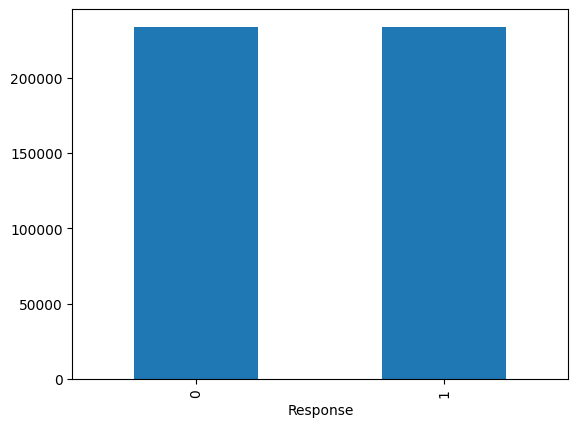

In [24]:

y_train_res.reset_index()["Response"].value_counts().plot(kind="bar")


In [24]:

lr = LinearRegression()
lr.fit(X_train,y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [24]:

pipe = Pipeline([
    # Here, Lor is a place holder: 
    ('classifier',LogisticRegression()) 
])


params = [
    
    # LOR:
    {
        'classifier':[LogisticRegression(class_weight="balanced",verbose=True)],
        'classifier__C':[0.1,0.2,0.3,0.4,0.5],
        'classifier__solver':['liblinear', 'newton-cg', 'newton-cholesky']
    },
    
    # RandomForest:
    {
        'classifier':[RandomForestClassifier()],
        'classifier__n_estimators':[20,30,40,50,60],
        'classifier__criterion':['gini','entropy','log_loss'],
        'classifier__class_weight':['balanced', 'balanced_subsample']
    },
    
    #Decision Tree:
    {
        'classifier':[DecisionTreeClassifier()],
        'classifier__criterion': ['gini','entropy','log_loss'],
        'classifier__splitter' : ["best","random"]
    }
]

In [25]:

# outof memeory: LOR=(3*5)=15 models, RF=(3*2*5) = 30 models, DT=(3*2)=6, total = 51 model train 
# cv = 5 total: 5*51= 255 model train: 
# again: 'newton-cg', 'newton-cholesky' does not support balanced class weight

# gc = GridSearchCV(estimator=pipe,param_grid=params,cv=5,verbose=True,scoring="accuracy")
# gc.fit(X_train,y_train)


In [26]:
X_train_res.shape

(468006, 14)

In [47]:

params = [
    
    # LOR:
    {
        'classifier':[LogisticRegression(class_weight="balanced",max_iter=1000)],
        'classifier__C':[0.1,0.5,1.0],
        'classifier__solver':['liblinear']
    },
    
    # Bagging:
    # {
    #     'classifier':[BaggingClassifier(random_state=42)],
    #     'classifier__n_estimators':[30,40,50],
    #     'classifier__max_features':[0.6,0.7,0.8],
    #     'classifier__max_samples':[0.5,0.6,0.7]
    # },
    # RandomForest:
    {
        'classifier':[RandomForestClassifier(random_state=42,n_jobs=1)],
        'classifier__n_estimators':[30,50],
        'classifier__max_depth':[3,4,5],
        'classifier__min_samples_leaf':[30,40,50],
        'classifier__min_samples_split':[50,60,70],
        'classifier__criterion':['gini','entropy','log_loss'],
        'classifier__class_weight':['balanced']
    },
    
    
    
    #Decision Tree:
    {
        'classifier':[DecisionTreeClassifier(random_state=42)],
        'classifier__criterion': ['gini','entropy','log_loss'],
        'classifier__max_depth':[3,4,5],
        'classifier__min_samples_leaf':[30,40,50],
        'classifier__min_samples_split':[50,60,70],
        'classifier__splitter' : ["best","random"]
    }
]


In [28]:



params = [
    
    # Bagging:
    {
        'classifier':[BaggingClassifier(random_state=42)],
        'classifier__n_estimators':[20,30,40,50],
        'classifier__max_features':[0.6,0.7,0.8],
        'classifier__max_samples':[0.5,0.6,0.7],
        'classifier__bootstrap':[True,False],
        'classifier__bootstrap_features':[True,False]
        
    },
]


In [29]:

# gc = GridSearchCV(
#     estimator=pipe,
#     n_jobs=1,
#     cv=3,
#     param_grid=params,
#     scoring="accuracy",
#     verbose=True
# )

# gc.fit(X_train,y_train)

In [30]:

# ======== Model Overfitting ========
""" 
Pipeline(steps=[('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=50, n_jobs=1,
                                        random_state=42))])
accuracy = 0.8684064526338298
"""
# print(gc.best_estimator_)
# print(gc.best_score_)


" \nPipeline(steps=[('classifier',\n                 RandomForestClassifier(class_weight='balanced',\n                                        n_estimators=50, n_jobs=1,\n                                        random_state=42))])\naccuracy = 0.8684064526338298\n"

In [31]:

# #
# # If our test accuracy will be bad than we can't understand with it. 
# # So, if we give test accuracy while doing then it will be good for GridSearchCV
# # The question is that which type of accuracy will be good?? -> 
# # f1 will be best: see from classification_report cause accuracy maybe = equal like below
# #

# rm = RandomForestClassifier(class_weight='balanced',n_estimators=50,n_jobs=1,random_state=42)
# rm.fit(X_train,y_train)

# print("Train_accuracy: ",cross_val_score(estimator=rm,X=X_train,y=y_train,cv=5,scoring="accuracy").mean())
# print("Test_accuracy: ",cross_val_score(estimator=rm,X=X_test,y=y_test,cv=5,scoring="accuracy").mean())


# y_pred = rm.predict(X_train)
# print("="*10,"Tranning Classification Repoart","="*10)
# print(classification_report(y_train,y_pred))

# print("="*10,"Testing Classification Repoart","="*10)
# y_pred = rm.predict(X_test)
# print(classification_report(y_test,y_pred))



In [48]:

# # === GridSearchCV with test_score ===

# # total: 981 fits not possible let's try randomsearchcv
# gc = GridSearchCV(
#     estimator=pipe,
#     n_jobs=1,
#     cv=3,
#     param_grid=params,
#     scoring=make_scorer(f1_score,average="macro"),
#     verbose=True
# )

# gc.fit(X_train,y_train)


rsc = RandomizedSearchCV(
    estimator=pipe,
    n_iter=20,
    n_jobs=1,
    cv=3,
    param_distributions=params,
    scoring=make_scorer(f1_score,average="macro"),
    return_train_score=True,
    verbose=True
)
rsc.fit(X_train,y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...egression())])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","[{'classifier': [LogisticRegre...max_iter=1000)], 'classifier__C': [0.1, 0.5, ...], 'classifier__solver': ['liblinear']}, {'classifier': [RandomForestC...ndom_state=42)], 'classifier__class_weight': ['balanced'], 'classifier__criterion': ['gini', 'entropy', ...], 'classifier__max_depth': [3, 4, ...], ...}, ...]"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",20
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",make_scorer(f...average=macro)
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KF

In [49]:

"""Result: 
Pipeline(steps=[('classifier',
                 DecisionTreeClassifier(criterion='entropy', random_state=42))])
accuracy = 0.6007302992208707
"""
print(rsc.best_estimator_)
print(rsc.best_score_)

Pipeline(steps=[('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='log_loss', max_depth=5,
                                        min_samples_leaf=50,
                                        min_samples_split=60, n_estimators=30,
                                        n_jobs=1, random_state=42))])
0.6037380494311373


In [50]:

rsc.cv_results_

{'mean_fit_time': array([4.68146229, 0.26440676, 0.16076136, 0.34979145, 0.32731279,
        0.13325111, 1.93505088, 4.52057838, 2.73060981, 0.41458527,
        0.39372786, 1.94779054, 2.61027201, 3.1812315 , 1.86091932,
        1.88103978, 3.16758355, 2.57156467, 0.33021188, 0.32227429]),
 'std_fit_time': array([0.44062388, 0.0061005 , 0.00921389, 0.00748837, 0.01478338,
        0.00262739, 0.0196861 , 0.13687866, 0.07106308, 0.00844982,
        0.0064727 , 0.04871111, 0.03039669, 0.08266781, 0.01512393,
        0.01049193, 0.05071808, 0.04579713, 0.02239958, 0.02035837]),
 'mean_score_time': array([0.19714077, 0.02618965, 0.02712146, 0.02416317, 0.0243775 ,
        0.02400001, 0.09370605, 0.21409154, 0.12879721, 0.02418454,
        0.02553455, 0.09914295, 0.12847185, 0.15364035, 0.09750501,
        0.09317287, 0.1453766 , 0.12378915, 0.02305905, 0.02453001]),
 'std_score_time': array([4.40962886e-03, 8.29646511e-04, 8.79361982e-04, 5.87839217e-04,
        1.18166521e-03, 1.20767381e-

In [54]:

estimator = RandomForestClassifier(class_weight='balanced',
                                        criterion='log_loss', max_depth=5,
                                        min_samples_leaf=50,
                                        min_samples_split=60, n_estimators=30,
                                        n_jobs=1, random_state=42)

rm = BaggingClassifier(estimator=estimator
                       ,bootstrap=True,
                       bootstrap_features=True,
                       max_features=0.8,
                       max_samples=0.7,
                       n_estimators=50,
                       oob_score=True,
                       random_state=42)
rm.fit(X_train,y_train)

,"estimator estimator: object, default=NoneThe base estimator to fit on random subsets of the dataset.If None, then the base estimator is a:class:`~sklearn.tree.DecisionTreeClassifier`... versionadded:: 1.2 `base_estimator` was renamed to `estimator`.",RandomForestC...ndom_state=42)
,"n_estimators n_estimators: int, default=10The number of base estimators in the ensemble.",50
,"max_samples max_samples: int or float, default=NoneThe number of samples to draw from X to train each base estimator (withreplacement by default, see `bootstrap` for more details).- If None, then draw `X.shape[0]` samples irrespective of `sample_weight`.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` unweighted samples or `max_samples * sample_weight.sum()` weighted samples.",0.7
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator (without replacement by default, see `bootstrap_features` for moredetails).- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.",0.8
,"bootstrap bootstrap: bool, default=TrueWhether samples are drawn with replacement. If False, sampling withoutreplacement is performed. If fitting with `sample_weight`, it isstrongly recommended to choose True, as only drawing with replacementwill ensure the expected frequency semantics of `sample_weight`.",True
,"bootstrap_features bootstrap_features: bool, default=FalseWhether features are drawn with replacement.",True
,"oob_score oob_score: bool, default=FalseWhether to use out-of-bag samples to estimatethe generalization error. Only available if bootstrap=True.",True
,"warm_start warm_start: bool, default=FalseWhen set to True, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fita whole new ensemble. See :term:`the Glossary `... versionadded:: 0.17 *warm_start* constructor parameter.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for both :meth:`fit` and:meth:`predict`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the random resampling of the original dataset(sample wise and feature wise).If the base estimator accepts a `random_state` attribute, a differentseed is generated for each instance in the ensemble.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: int, default=0Controls the verbosity when fitting and predicting.",0


In [ ]:

y_pred = rm.predict(X_train)
print("="*10,"Tranning Classification Repoart","="*10)
print(classification_report(y_train,y_pred))

print("="*10,"Testing Classification Repoart","="*10)
y_pred = rm.predict(X_test)
print(classification_report(y_test,y_pred))

#
# test data: “model যখন 0 predict করে তার 98% 0 হয়,
#কিন্তু real dataset এর মাত্র 68% 0 কে সঠিক বলেছে”
#

# === Tips:
# Try with bagging but If test data accuacy less than 0.5 then should change the algoritrm.
#



========== Tranning Classification Repoart ==========
              precision    recall  f1-score   support

           0       0.99      0.64      0.78    234003
           1       0.27      0.95      0.42     32773

    accuracy                           0.68    266776
   macro avg       0.63      0.79      0.60    266776
weighted avg       0.90      0.68      0.74    266776

========== Testing Classification Repoart ==========
              precision    recall  f1-score   support

           0       0.99      0.65      0.78    100396
           1       0.27      0.95      0.42     13937

    accuracy                           0.68    114333
   macro avg       0.63      0.80      0.60    114333
weighted avg       0.90      0.68      0.74    114333



In [55]:

# if oob score near to test accuracy then overfiting is reducing: 
rm.oob_score_

0.6796413470477104

In [ ]:

from imblearn.pipeline import Pipeline  

over = SMOTE(random_state=42, k_neighbors=3, sampling_strategy=0.7)  # Minority to 50% of majority
under = RandomUnderSampler(random_state=42, sampling_strategy=0.8, replacement=False)# majority:minority= to 1:0.8

resample_pipe = Pipeline([
    ('over', over),
    ('under', under)
])

X_train_res, y_train_res = resample_pipe.fit_resample(X_train, y_train)  

# model
estimator = RandomForestClassifier(
    class_weight='balanced_subsample',
    criterion='log_loss',
    max_depth=5,
    min_samples_leaf=50,
    min_samples_split=60,
    n_estimators=30,
    n_jobs=1,
    random_state=42
)

rm = BaggingClassifier(
    estimator=estimator,
    bootstrap=True,
    bootstrap_features=True,
    max_features=0.8,
    max_samples=0.7,
    n_estimators=50,
    oob_score=True,
    random_state=42
)

rm.fit(X_train_res, y_train_res)

# After fitting, print reports
from sklearn.metrics import classification_report

print("========== Training Classification Report ==========")
print(classification_report(y_train_res, rm.predict(X_train_res)))

print("========== Testing Classification Report ==========")
print(classification_report(y_test, rm.predict(X_test)))  

print("OOB Score:", rm.oob_score_)


========== Training Classification Report ==========
              precision    recall  f1-score   support

           0       0.96      0.65      0.77    204752
           1       0.69      0.97      0.80    163802

    accuracy                           0.79    368554
   macro avg       0.82      0.81      0.79    368554
weighted avg       0.84      0.79      0.78    368554

========== Testing Classification Report ==========
              precision    recall  f1-score   support

           0       0.99      0.65      0.78    100396
           1       0.27      0.94      0.42     13937

    accuracy                           0.68    114333
   macro avg       0.63      0.79      0.60    114333
weighted avg       0.90      0.68      0.74    114333

OOB Score: 0.7872849026194262


In [22]:

from sklearn.metrics import precision_recall_curve, classification_report
import numpy as np

# Predict probabilities on test
probs = rm.predict_proba(X_test)[:, 1]  # Prob for class 1

# Find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test, probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print("Best Threshold:", best_threshold, "Best F1:", f1_scores[best_idx])

# Predict with new threshold
preds = (probs >= best_threshold).astype(int)
print("Adjusted Test Report:\n", classification_report(y_test, preds))


Best Threshold: 0.6636940462892642 Best F1: 0.4458906351917081
Adjusted Test Report:
               precision    recall  f1-score   support

           0       0.96      0.76      0.85    100396
           1       0.31      0.78      0.45     13937

    accuracy                           0.76    114333
   macro avg       0.64      0.77      0.65    114333
weighted avg       0.88      0.76      0.80    114333





# `# Hyperparameter-tuning with optuna:`


In [8]:
import numpy as np 
np.arange(0.4,1,0.1)

array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [21]:
import optuna
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


def Objective(trial):

    sampling_name = trial.suggest_categorical("sampling", ["over", "under", "real"])
    classifier_name = trial.suggest_categorical("classifier", ["dt", "rf"])

    # ===== Sampling =====
    if sampling_name == "over":
        strategy = trial.suggest_float("sampling_strategy", 0.4, 0.9, step=0.1)
        k_neighbors = trial.suggest_int("k_neighbors", 3, 7,step=1)
        sampling = SMOTE(
            sampling_strategy=strategy,
            k_neighbors=k_neighbors,
            random_state=42
        )

    elif sampling_name == "under":
        strategy = trial.suggest_float("sampling_strategy", 0.4, 0.9, step=0.1)
        replacement = trial.suggest_categorical("replacement", [True, False])
        sampling = RandomUnderSampler(
            sampling_strategy=strategy,
            replacement=replacement,
            random_state=42
        )

    else:
        sampling = "passthrough"

    # ===== Model =====
    if classifier_name == "dt":
        model = DecisionTreeClassifier(
            max_depth=trial.suggest_int("max_depth", 3, 10),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 50, 100, step=2),
            min_samples_split=trial.suggest_int("min_samples_split", 50, 200, step=5),
            criterion=trial.suggest_categorical(
                "criterion", ["gini", "entropy", "log_loss"]
            ),
            random_state=42
        )

    else:
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", 30, 200, step=5),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 50, 100, step=2),
            min_samples_split=trial.suggest_int("min_samples_split", 50, 200, step=5),
            criterion=trial.suggest_categorical(
                "criterion", ["gini", "entropy", "log_loss"]
            ),
            random_state=42,
            n_jobs=-1
        )

    # ===== Pipeline =====
    pipe = Pipeline([
        ("sampling", sampling),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    score = f1_score(y_test, y_pred, average="macro")
    return score



In [22]:


study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(),study_name="dtrf")
study.optimize(Objective,n_trials=50)



[I 2026-01-09 14:28:16,926] A new study created in memory with name: dtrf
[I 2026-01-09 14:28:21,317] Trial 0 finished with value: 0.6454343646851113 and parameters: {'sampling': 'over', 'classifier': 'dt', 'sampling_strategy': 0.6000000000000001, 'k_neighbors': 6, 'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 90, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.6454343646851113.
[I 2026-01-09 14:29:04,285] Trial 1 finished with value: 0.6471917178740136 and parameters: {'sampling': 'over', 'classifier': 'rf', 'sampling_strategy': 0.7000000000000001, 'k_neighbors': 5, 'n_estimators': 135, 'min_samples_leaf': 84, 'min_samples_split': 65, 'criterion': 'gini'}. Best is trial 1 with value: 0.6471917178740136.
[I 2026-01-09 14:30:05,501] Trial 2 finished with value: 0.6471390381055677 and parameters: {'sampling': 'over', 'classifier': 'rf', 'sampling_strategy': 0.7000000000000001, 'k_neighbors': 6, 'n_estimators': 190, 'min_samples_leaf': 86, 'min_samples_split': 65, 

In [25]:

df = study.trials_dataframe()
df.to_csv("optua_study.csv")

In [24]:

optuna_study = pd.read_csv("optua_study.csv")
optuna_study[optuna_study.sort_values("value",ascending=False)["params_classifier"]=="rf"].iloc[:2,:]

/tmp/ipykernel_32644/1403563133.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  optuna_study[optuna_study.sort_values("value",ascending=False)["params_classifier"]=="rf"].iloc[:2,:]


,Unnamed: 0,number,value,datetime_start,datetime_complete,duration,params_classifier,params_criterion,params_k_neighbors,params_max_depth,params_min_samples_leaf,params_min_samples_split,params_n_estimators,params_replacement,params_sampling,params_sampling_strategy,state
1,1,1,0.647192,2026-01-09 14:28:21.318601,2026-01-09 14:29:04.285068,0 days 00:00:42.966467,rf,gini,5.0,NaN,84,65,135.0,NaN,over,0.7,COMPLETE
2,2,2,0.647139,2026-01-09 14:29:04.285809,2026-01-09 14:30:05.501152,0 days 00:01:01.215343,rf,entropy,6.0,NaN,86,65,190.0,NaN,over,0.7,COMPLETE


In [26]:
optuna_study[optuna_study.sort_values("value",ascending=False)["params_classifier"]=="dt"].iloc[:2,:]

/tmp/ipykernel_32644/594909167.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  optuna_study[optuna_study.sort_values("value",ascending=False)["params_classifier"]=="dt"].iloc[:2,:]


,Unnamed: 0,number,value,datetime_start,datetime_complete,duration,params_classifier,params_criterion,params_k_neighbors,params_max_depth,params_min_samples_leaf,params_min_samples_split,params_n_estimators,params_replacement,params_sampling,params_sampling_strategy,state
0,0,0,0.645434,2026-01-09 14:28:16.930501,2026-01-09 14:28:21.317350,0 days 00:00:04.386849,dt,log_loss,6.0,10.0,50,90,NaN,NaN,over,0.6,COMPLETE
3,3,3,0.471285,2026-01-09 14:30:05.502059,2026-01-09 14:30:06.603805,0 days 00:00:01.101746,dt,entropy,NaN,9.0,62,55,NaN,NaN,real,NaN,COMPLETE


In [21]:


# oversamping: k_neighbours=6,strategy=0.6
dt = DecisionTreeClassifier(
    criterion="log_loss",
    max_depth=10,
    min_samples_leaf=50,
    min_samples_split=90
)


# over: k_neighbors:5,strategy:0.7
rf = RandomForestClassifier(
    criterion="gini",
    min_samples_split=65,
    n_estimators=195,   
)


votinPipe = Pipeline(
    [('classifier',LogisticRegression())]
)


params = [
    {
        'classifier':[VotingClassifier(estimators=[('dt',dt),('rf',rf)])],
        'classifier__voting':['hard','soft'],
        #'classifier__weights':np.arange(0,1,0.1),use SMOTE
        'classifier__flatten_transform':[True,False]
    }
]


cv = GridSearchCV(
    estimator=votinPipe,
    param_grid=params,
    scoring=make_scorer(f1_score,average="macro"),
    verbose=True,
    cv=3,
    return_train_score=True
)

emb = SMOTE(sampling_strategy=0.6,random_state=42,k_neighbors=5)
X_train_res,y_train_res = emb.fit_resample(X_train,y_train)

cv.fit(X_train,y_train)



Fitting 3 folds for each of 4 candidates, totalling 12 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...egression())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'classifier': [VotingClassif...mators=195))])], 'classifier__flatten_transform': [True, False], 'classifier__voting': ['hard', 'soft']}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",make_scorer(f...average=macro)
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the c

In [28]:

# for calibaration curve fit the dt and rf model:
dt.fit(X_train_res,y_train_res)
rf.fit(X_train_res,y_train_res)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",195
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",65
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metri

In [22]:
""" 
Pipeline(steps=[('classifier',
                 VotingClassifier(estimators=[('dt',
                                               DecisionTreeClassifier(criterion='log_loss',
                                                                      max_depth=10,
                                                                      min_samples_leaf=50,
                                                                      min_samples_split=90)),
                                              ('rf',
                                               RandomForestClassifier(min_samples_split=65,
                                                                      n_estimators=195))],
                                  flatten_transform=False))])
0.8209447072961181
"""
print(cv.best_estimator_)
print(cv.best_score_)

Pipeline(steps=[('classifier',
                 VotingClassifier(estimators=[('dt',
                                               DecisionTreeClassifier(criterion='log_loss',
                                                                      max_depth=10,
                                                                      min_samples_leaf=50,
                                                                      min_samples_split=90)),
                                              ('rf',
                                               RandomForestClassifier(min_samples_split=65,
                                                                      n_estimators=195))],
                                  voting='soft'))])
0.4753194856485079


In [ ]:


# oversamping: k_neighbours=6,strategy=0.6
dt = DecisionTreeClassifier(
    criterion="log_loss",
    max_depth=10,
    min_samples_leaf=50,
    min_samples_split=90
)


# over: k_neighbors:5,strategy:0.7
rf = RandomForestClassifier(
    criterion="gini",
    min_samples_split=65,
    n_estimators=195,   
)


# emb = SMOTE(sampling_strategy=0.6,random_state=42,k_neighbors=5)
# X_train_res,y_train_res = emb.fit_resample(X_train,y_train)
emb = ADASYN(sampling_strategy=0.6,random_state=42,n_neighbors=5)
X_train_adap_res,y_train_adap_res = emb.fit_resample(X_train,y_train)
#
# voting="soft" has predict proba: But it's decrease the accuracy:
#  
#| ------ | ----------------- | --------------------------------------------- |
#| hard   | `predict()`       | probability ভুল হলেও class ঠিক হতে পারে         |
#| soft   | `predict_proba()` | **mis-calibrated probability → decision ভুল**  |
#
vt = VotingClassifier(estimators=[('rf',rf),('dt',dt)],voting="hard",flatten_transform=False,verbose=True)
vt.fit(X_train_adap_res,y_train_adap_res)



[Voting] ....................... (1 of 2) Processing rf, total= 2.8min
[Voting] ....................... (2 of 2) Processing dt, total=   2.7s


,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('rf', ...), ('dt', ...)]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'hard'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",False
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",True
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",195
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",65
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1


In [28]:

y_predict_prob = vt.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test,y_predict_prob)
recall = (precision*recall)/(precision+recall+1e-10)
best_idx = np.argmax(recall)
best_threshold = thresholds[best_idx]
print("best threshold: ",best_threshold , " at recall: ",recall[best_idx])

best threshold:  1  at recall:  0.21604746357608007


In [30]:


"""With 
---Voting SMOTE: ---
0       0.94      0.79      0.86    234003
1       0.72      0.92      0.81    140401

---Bagging SMOTE---
0       0.96      0.65      0.77    204752
1       0.69      0.97      0.80    163802

"""

print("==== Trannign Result ====")
y_pred = vt.predict(X_train_adap_res)
print(classification_report(y_true=y_train_adap_res,y_pred=y_pred))

print()

print("==== Testing Result ====")
y_pred = vt.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_pred))



==== Trannign Result ====
              precision    recall  f1-score   support

           0       0.91      0.87      0.89    234003
           1       0.81      0.87      0.84    148346

    accuracy                           0.87    382349
   macro avg       0.86      0.87      0.86    382349
weighted avg       0.87      0.87      0.87    382349


==== Testing Result ====
              precision    recall  f1-score   support

           0       0.94      0.84      0.88    100396
           1       0.34      0.60      0.43     13937

    accuracy                           0.81    114333
   macro avg       0.64      0.72      0.66    114333
weighted avg       0.86      0.81      0.83    114333



In [31]:


# save the model:
import pickle 
filename = "voting_model.pkl"
pickle.dump(vt,open(filename,'wb'))



In [23]:

# [probabilty_of_class_0    prabolility_of_class_1]
vt.predict_proba(X_test)

array([[4.29675300e-01, 5.70324700e-01],
       [3.62320275e-01, 6.37679725e-01],
       [4.73668004e-01, 5.26331996e-01],
       ...,
       [6.44106853e-01, 3.55893147e-01],
       [9.99382462e-01, 6.17537562e-04],
       [9.99908821e-01, 9.11786626e-05]], shape=(114333, 2))

In [25]:


dt_calib = CalibratedClassifierCV(
    estimator=dt,
    method='isotonic',
    cv=5
)

rf_calib = CalibratedClassifierCV(
    estimator=rf,
    method="sigmoid",
    cv=5
)

dt_calib.fit(X_train_res,y_train_res)
rf_calib.fit(X_train_res,y_train_res)



,"estimator estimator: estimator instance, default=NoneThe classifier whose output need to be calibrated to provide moreaccurate `predict_proba` outputs. The default classifier isa :class:`~sklearn.svm.LinearSVC`... versionadded:: 1.2",RandomForestC...stimators=195)
,"method method: {'sigmoid', 'isotonic', 'temperature'}, default='sigmoid'The method to use for calibration. Can be:- 'sigmoid', which corresponds to Platt's method (i.e. a binary logistic regression model).- 'isotonic', which is a non-parametric approach.- 'temperature', temperature scaling.Sigmoid and isotonic calibration methods natively support only binaryclassifiers and extend to multi-class classification using a One-vs-Rest (OvR)strategy with post-hoc renormalization, i.e., adjusting the probabilities aftercalibration to ensure they sum up to 1.In contrast, temperature scaling naturally supports multi-class calibration byapplying `softmax(classifier_logits/T)` with a value of `T` (temperature)that optimizes the log loss.For very uncalibrated classifiers on very imbalanced datasets, sigmoidcalibration might be preferred because it fits an additional interceptparameter. This helps shift decision boundaries appropriately when theclassifier being calibrated is biased towards the majority class.Isotonic calibration is not recommended when the number of calibration samplesis too low ``(≪1000)`` since it then tends to overfit... versionchanged:: 1.8 Added option 'temperature'.",'sigmoid'
,"cv cv: int, cross-validation generator, or iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross-validation,- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. If ``y`` isneither binary nor multiclass, :class:`~sklearn.model_selection.KFold`is used.Refer to the :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors.Base estimator clones are fitted in parallel across cross-validationiterations.See :term:`Glossary ` for more details... versionadded:: 0.24",None
,"ensemble ensemble: bool, or ""auto"", default=""auto""Determines how the calibrator is fitted.""auto"" will use `False` if the `estimator` is a:class:`~sklearn.frozen.FrozenEstimator`, and `True` otherwise.If `True`, the `estimator` is fitted using training data, andcalibrated using testing data, for each `cv` fold. The final estimatoris an ensemble of `n_cv` fitted classifier and calibrator pairs, where`n_cv` is the number of cross-validation folds. The output is theaverage predicted probabilities of all pairs.If `False`, `cv` is used to compute unbiased predictions, via:func:`~sklearn.model_selection.cross_val_predict`, which are thenused for calibration. At prediction time, the classifier used is the`estimator` trained on all the data.Note that this method is also internally implemented in:mod:`sklearn.svm` estimators with the `probabilities=True` parameter... versionadded:: 0.24.. versionchanged:: 1.6 `""auto""` option is added and is the default.",'auto'
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",195
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'


In [26]:

vt_calib = CalibratedClassifierCV(
    estimator=vt,
    method='sigmoid',
    cv=5
)

vt_calib.fit(X_train_res,y_train_res)


[Voting] ....................... (1 of 2) Processing rf, total= 2.5min
[Voting] ....................... (2 of 2) Processing dt, total=   1.7s
[Voting] ....................... (1 of 2) Processing rf, total= 2.3min
[Voting] ....................... (2 of 2) Processing dt, total=   2.4s
[Voting] ....................... (1 of 2) Processing rf, total= 1.9min
[Voting] ....................... (2 of 2) Processing dt, total=   1.7s
[Voting] ....................... (1 of 2) Processing rf, total= 2.1min
[Voting] ....................... (2 of 2) Processing dt, total=   1.7s
[Voting] ....................... (1 of 2) Processing rf, total= 2.0min
[Voting] ....................... (2 of 2) Processing dt, total=   1.7s


,"estimator estimator: estimator instance, default=NoneThe classifier whose output need to be calibrated to provide moreaccurate `predict_proba` outputs. The default classifier isa :class:`~sklearn.svm.LinearSVC`... versionadded:: 1.2",VotingClassif...voting='soft')
,"method method: {'sigmoid', 'isotonic', 'temperature'}, default='sigmoid'The method to use for calibration. Can be:- 'sigmoid', which corresponds to Platt's method (i.e. a binary logistic regression model).- 'isotonic', which is a non-parametric approach.- 'temperature', temperature scaling.Sigmoid and isotonic calibration methods natively support only binaryclassifiers and extend to multi-class classification using a One-vs-Rest (OvR)strategy with post-hoc renormalization, i.e., adjusting the probabilities aftercalibration to ensure they sum up to 1.In contrast, temperature scaling naturally supports multi-class calibration byapplying `softmax(classifier_logits/T)` with a value of `T` (temperature)that optimizes the log loss.For very uncalibrated classifiers on very imbalanced datasets, sigmoidcalibration might be preferred because it fits an additional interceptparameter. This helps shift decision boundaries appropriately when theclassifier being calibrated is biased towards the majority class.Isotonic calibration is not recommended when the number of calibration samplesis too low ``(≪1000)`` since it then tends to overfit... versionchanged:: 1.8 Added option 'temperature'.",'sigmoid'
,"cv cv: int, cross-validation generator, or iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross-validation,- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. If ``y`` isneither binary nor multiclass, :class:`~sklearn.model_selection.KFold`is used.Refer to the :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors.Base estimator clones are fitted in parallel across cross-validationiterations.See :term:`Glossary ` for more details... versionadded:: 0.24",None
,"ensemble ensemble: bool, or ""auto"", default=""auto""Determines how the calibrator is fitted.""auto"" will use `False` if the `estimator` is a:class:`~sklearn.frozen.FrozenEstimator`, and `True` otherwise.If `True`, the `estimator` is fitted using training data, andcalibrated using testing data, for each `cv` fold. The final estimatoris an ensemble of `n_cv` fitted classifier and calibrator pairs, where`n_cv` is the number of cross-validation folds. The output is theaverage predicted probabilities of all pairs.If `False`, `cv` is used to compute unbiased predictions, via:func:`~sklearn.model_selection.cross_val_predict`, which are thenused for calibration. At prediction time, the classifier used is the`estimator` trained on all the data.Note that this method is also internally implemented in:mod:`sklearn.svm` estimators with the `probabilities=True` parameter... versionadded:: 0.24.. versionchanged:: 1.6 `""auto""` option is added and is the default.",'auto'
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",195
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'


In [30]:

# ** here, we need the clalibration on minority classs. 

# == dt ==
y_prob_dt = dt.predict_proba(X_test)[:,1]
y_prob_calib_dt = dt_calib.predict_proba(X_test)[:,1]


# == rf ==
y_prob_rf = rf.predict_proba(X_test)[:,1]
y_prob_calib_rf = rf_calib.predict_proba(X_test)[:,1]


# == vt ==
y_prob_vt = vt.predict_proba(X_test)[:,1]
y_prob_calib_vt = vt_calib.predict_proba(X_test)[:,1]


# claibration curve vlaues:
true_prob_dt, mean_predicted_prob_dt = calibration_curve(y_test,y_prob_dt,n_bins=10)
true_prob_calib_dt , mean_predicted_calib_prob_dt = calibration_curve(y_test,y_prob_calib_dt,n_bins=10)

true_prob_rf, mean_predicted_prob_rf = calibration_curve(y_test,y_prob_rf,n_bins=10)
true_prob_calib_rf, mean_predicted_calib_prob_rf = calibration_curve(y_test,y_prob_calib_rf,n_bins=10)

true_prob_vt,mean_predicted_prob_vt = calibration_curve(y_test,y_prob_vt,n_bins=10)
true_prob_calib_vt, mean_predicted_calib_prob_vt = calibration_curve(y_test,y_prob_calib_vt,n_bins=10)



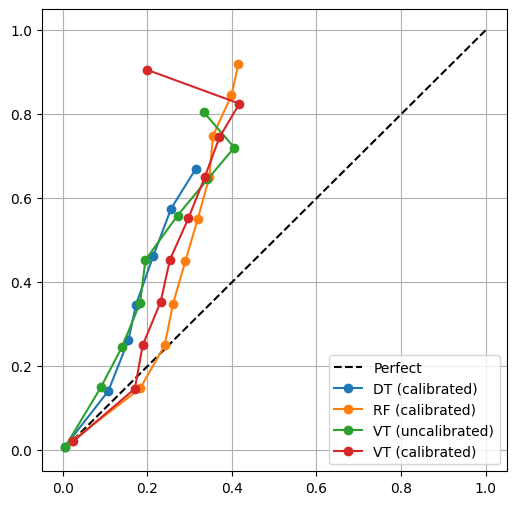

In [39]:


# Calibration vs Non-Calibration Curve:

plt.figure(figsize=(6,6))
plt.plot([1,0],[1,0],'k--',label="Perfect")

# plt.plot(true_prob_dt,mean_predicted_prob_dt,'o-',label="DT (uncalibrated)")
plt.plot(true_prob_calib_dt,mean_predicted_calib_prob_dt,'o-',label="DT (calibrated)")


# plt.plot(true_prob_rf,mean_predicted_prob_rf,'o-',label="RF (uncalibrated)")
plt.plot(true_prob_calib_rf,mean_predicted_calib_prob_rf,'o-',label="RF (calibrated)")


plt.plot(true_prob_vt,mean_predicted_prob_vt,'o-',label="VT (uncalibrated)")
plt.plot(true_prob_calib_vt,mean_predicted_calib_prob_vt,'o-',label="VT (calibrated)")

plt.legend()
plt.grid()
plt.show()



<br>
<br>

# `# Adaboot with optuna :` 

<br>
<br>

In [21]:
import optuna
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold,cross_val_score



emb = SMOTE(sampling_strategy=0.6,random_state=42,k_neighbors=5)
X_train_res,y_train_res = emb.fit_resample(X_train,y_train)


def Objective(trial):
    n_estimators = trial.suggest_int("n_estimators",50,200,step=10)
    learing_rate = trial.suggest_float("learning_rate",0.1,1,log=True)
    max_depth = trial.suggest_int("max_depth",1,3)
    #algorithrm = trial.suggest_categorical("algorithm",['SAMME','SAMME.R'])
    model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=max_depth),
                               n_estimators=n_estimators,learning_rate=learing_rate,random_state=42)
    
    model.fit(X_train_res,y_train_res)
    cv = StratifiedKFold(shuffle=True,random_state=42)
    score = cross_val_score(model,X_train_res,y_train_res,scoring="f1",cv=cv)
    return score.mean()



/home/yasin/all_program/vehicle_insurance_end_2_end_project/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:

study = optuna.create_study(sampler=optuna.samplers.TPESampler(),direction="maximize",study_name="-adabost-")
study.optimize(Objective,n_trials=50)


[I 2026-01-11 16:07:01,369] A new study created in memory with name: -adabost-
[I 2026-01-11 16:14:37,366] Trial 0 finished with value: 0.7616023397932399 and parameters: {'n_estimators': 130, 'learning_rate': 0.3162945419159513, 'max_depth': 3}. Best is trial 0 with value: 0.7616023397932399.
[I 2026-01-11 16:18:27,295] Trial 1 finished with value: 0.7510680337601029 and parameters: {'n_estimators': 160, 'learning_rate': 0.4486738206087231, 'max_depth': 1}. Best is trial 0 with value: 0.7616023397932399.
[I 2026-01-11 16:28:58,460] Trial 2 finished with value: 0.763312414984848 and parameters: {'n_estimators': 170, 'learning_rate': 0.33016120878324345, 'max_depth': 3}. Best is trial 2 with value: 0.763312414984848.
[I 2026-01-11 16:32:09,219] Trial 3 finished with value: 0.7515581945274727 and parameters: {'n_estimators': 140, 'learning_rate': 0.23583629346888402, 'max_depth': 1}. Best is trial 2 with value: 0.763312414984848.
[I 2026-01-11 16:36:36,918] Trial 4 finished with value: 0

In [23]:

df = study.trials_dataframe()
df.to_csv("adaboost1.csv")


In [24]:
study.best_params

{'n_estimators': 190, 'learning_rate': 0.9996891999160135, 'max_depth': 3}